<h1 align="center"> Metody Obliczeniowe w Nauce i Technicie </h1>
<h2 align="center"> Laboratorium 5 </h2>
<h2 align="center"> Symulowane wyżarzanie </h2>
<h3 align="center"> Problem TSP </h3>
<h3 align="center"> Mateusz Praski </h3>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from anneal import SimulatedAnnealing as Anneal
from numba import jit
from random import randrange, random
from scipy.stats import multivariate_normal as mvn
from math import sqrt, floor, log
from celluloid import Camera

# Generowanie zbiorów testowych

## Zbiór n losowych miast

Miasta są generowane niezależnie od siebie z rozkładem jednostajnym na przedziale \[0, 1)

In [2]:
def generate_random_cities(n: int) -> np.ndarray:
    return np.random.rand(n, 2)

Funkcja pomocnicza do rysowania miast oraz ich rozwiązań

In [3]:
def plot_cities(ax, cities, path = None):
    ax.scatter(cities[:,0], cities[:,1], s=10)
    if path is not None:
        if len(path) != cities.shape[0]:
            raise ValueError('Cities and path have different sizes!')
        cities_path = cities.copy()
        for i, j in enumerate(path):
            cities_path[i,:] = cities[j,:]
        cities_path = np.vstack((cities_path, cities_path[0,:]))
        ax.plot(cities_path[:,0], cities_path[:, 1])

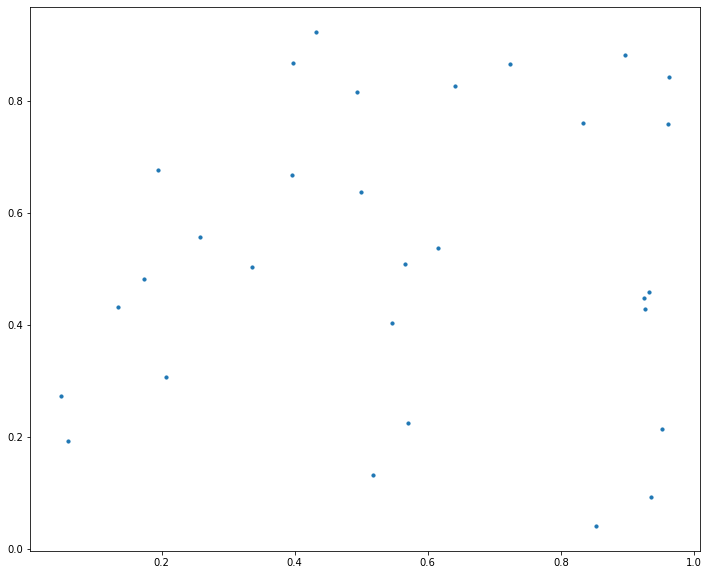

In [4]:
cities = generate_random_cities(30)
fig, ax = plt.subplots(1)
fig.set_size_inches(12, 10)
plot_cities(ax, cities)

## Miasta z rozkładem normalnym

Funkcja generuje $4k$ miast, każda grupa $k$ miast pochodzi z rozkładu normalnego $N(\mu_i, \Sigma_i)$

In [5]:
def generate_normal_cities(k, mu, sigma):
    if len(mu) != 4 or len(sigma) != 4:
        raise ValueError('Wrong size of the parameters')
    cities = np.empty((4*k, 2))
    for i in range(4):
        cities[k*i: (k*(i+1))] = mvn.rvs(mean=mu[i], cov=sigma[i], size=k)
    
    return cities

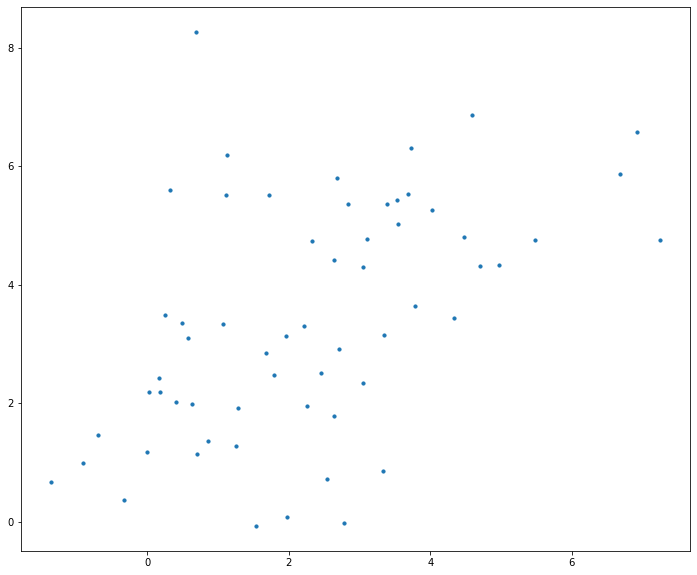

In [6]:
cities = generate_normal_cities(15,
    [[1, 1], [3, 5], [5, 5], [2, 2]], [2, 2, 1, 1]
)
fig, ax = plt.subplots(1)
fig.set_size_inches(12, 10)
plot_cities(ax, cities)

## Graf w postaci 9 grup miast

Metoda generuje $9k$ punktów, każda grupa $k$ jest generowana z rozkładem jednostajnym wewnątrz koła o środku w $c_i$ i promieniu $r_i$

In [7]:
def generate_circle_cities(k, centers, radiuses):
    cities = np.empty((9*k, 2))
    
    for i in range(9):
        D = (2 * radiuses[i]) * np.random.rand(k) - radiuses[i]
        A = np.random.rand(k) * 2 * np.pi
        cities[k*i:k*(i+1), 0] = np.cos(A) * D
        cities[k*i:k*(i+1), 1] = np.sin(A) * D
        cities[k*i:k*(i+1), :] += centers[i]
    return cities

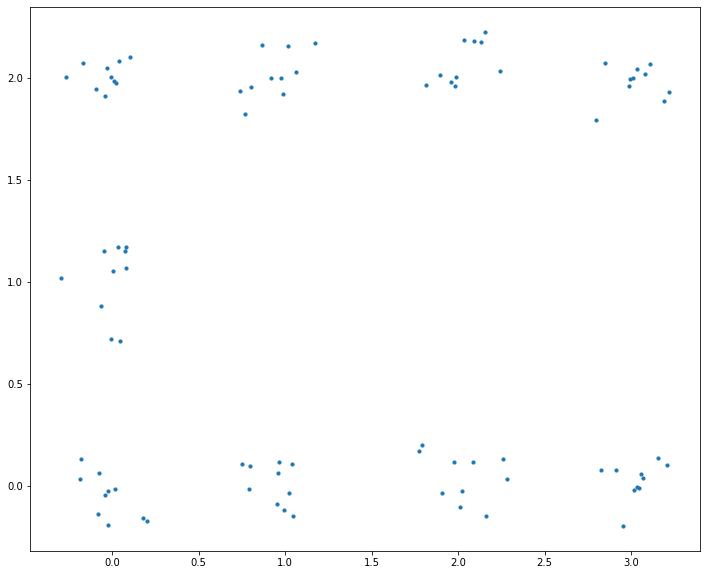

In [8]:
cities = generate_circle_cities(10,
    [[0, 0], [0, 1], [0, 2], [1, 2], [2, 2], [3, 2], [3, 0], [2, 0], [1, 0]], [0.3]*9
)
fig, ax = plt.subplots(1)
fig.set_size_inches(12, 10)
plot_cities(ax, cities)

# Model symulowanego wyżarzania

Jest to rozszerzenie klasy `SimulatedAnnealing` z pliku `anneal.py`, która zawiera implementcję podstawowych metod (inicjalizacja, zapisywania stanów oraz algorytm wyżarzania). Poniżej zostały rozszerzone funkcje określające zasady wyżarzania dla TSP

In [41]:
class TSPAnneal(Anneal):
    def __init__(self, cities, use_arbitrary: bool = True):
        super().__init__()
        self.cities = cities
        self.init = self.basic_init
        if use_arbitrary:
            self.get_neighbour = self.from_arbitrary_swap
        else:
            self.get_neighbour = self.from_consecutive_swap
        
    # Funkcja generująca losowy stan początkowy
    def basic_init(self):
        return np.random.permutation(np.arange(self.cities.shape[0]))
        
    # Funkcja kosztu (energii) rozwiązania
    def cost(self, solution):
        last_city = solution[0]
        score = 0
        for i in solution[1:]:
            score += np.linalg.norm(self.cities[last_city, :] - self.cities[i, :])
            last_city = i
        return score + np.linalg.norm(self.cities[last_city, :] - self.cities[solution[0], :])
        
    # Zamiana dwóch losowych puntków na trasie
    @staticmethod
    def from_arbitrary_swap(solution: np.ndarray) -> np.ndarray:
        new_sol = solution.copy()
        first, second = randrange(solution.shape[0]), randrange(solution.shape[0])
        while second == first:
            second = randrange(solution.shape[0])
        new_sol[first], new_sol[second] = new_sol[second], new_sol[first]
        return new_sol
    
    @staticmethod
    def from_consecutive_swap(solution: np.ndarray) -> np.ndarray:
        new_sol = solution.copy()
        first = randrange(solution.shape[0])
        if random() >= 0.5:
            if first == solution.shape[0] - 1:
                second = 0
            else:
                second = first + 1
        else:
            second = first - 1
        new_sol[first], new_sol[second] = new_sol[second], new_sol[first]
        return new_sol

Powyższa implementacja symulowanego wyżarzania daje nam 4 hiperpametry względem funkcji temperatury oraz jeden hiperparametr w postaci doboru sąsiedztwa. W przypadku temperatury parametrami są:

- $T_0$: początkowa temperatura układu, od której zależy początkowe prawdopodobieńsywo przyjęcia gorszego rozwiązania.
- $\alpha$: Parametr schematu wyżarzania. Odpowiada za szybkość spadku temperatury,
- $\epsilon$: Warunek stopu. Proces wyżarzania zostaje zatrzymany gdy temperatura spadnie poniżej tej wartości,
- Funkcja temperatury.

Zaimplementowane zostały 2 sposoby spadku temperatury:

- Wykładnicza: $T_n = \alpha T_{n-1}$
- Liniowa: $T_n = T_{n-1} - \alpha$

# Przykładowe rozwiązania różnych typów problemu

In [10]:
def show_example(cities, T0=sqrt, alpha=0.998, epsilon=1e-7):
    model = TSPAnneal(cities)
    sol, score = model.fit(
        initial_temp=T0(cities.shape[0]),
        alpha=alpha,
        max_stagnation=1000,
        epsilon=epsilon
    )
    fig, axes = plt.subplots(1, 2)
    plot_cities(axes[0], cities, sol)
    axes[0].set_title('Otrzymane rozwiązanie')
    
    story = model.story
    x = list(range(len(story)))
    y = [u[1] for u in story]
    axes[1].plot(x, y)
    axes[1].set_title('Entropia układu w czasie')
    axes[1].set_xlabel('Numer epoki')
    axes[1].set_ylabel('Koszt rozwiązania')
    fig.set_size_inches(10, 5)

## Zbiory losowe

### N = 10

Current temperature: 0.00040115714780146044 	 Current solution: 2.9880747444332734 	 Best solution: 2.9880747444332734 		Number of epochs without improvement reached max_stagnation

Number of epochs: 1791


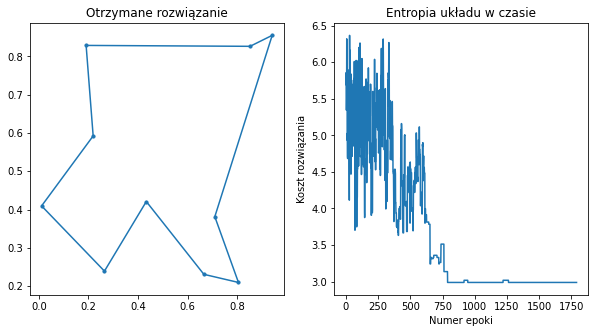

In [75]:
N = 10

cities = generate_random_cities(N)
show_example(cities, alpha=0.995)

### N = 30

Current temperature: 0.00015135215084841847 	 Current solution: 5.018589856676352 	 Best solution: 5.018589856676352 		Number of epochs without improvement reached max_stagnation

Number of epochs: 5244


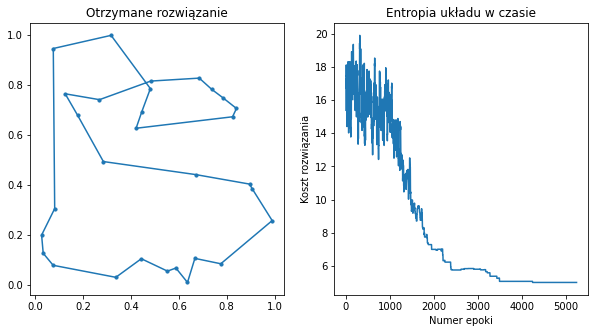

In [76]:
N = 30

cities = generate_random_cities(N)
show_example(cities)

# N = 50

Current temperature: 3.5047924157323244e-06 	 Current solution: 8.472563995670434 	 Best solution: 8.472563995670434 		Number of epochs without improvement reached max_stagnation

Number of epochs: 9672


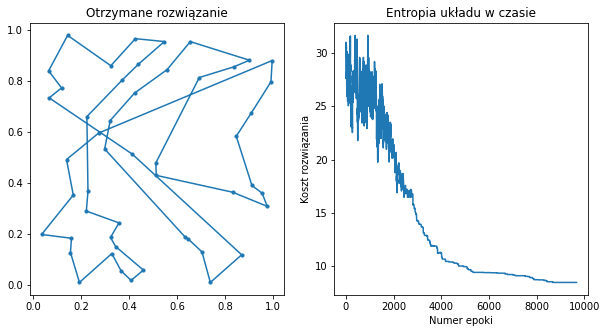

In [87]:
N = 50

cities = generate_random_cities(N)
show_example(cities, alpha=0.9985)

## Zbiory z rozkładem normalnym

- $\Sigma = \textbf{1}$
- $\mu \sim \text{Uniform}(0, 5)$
- $k=10$

Current temperature: 0.006288595161269005 	 Current solution: 33.22368451030671 	 Best solution: 33.21245636037112 		Number of epochs without improvement reached max_stagnation

Number of epochs: 6911


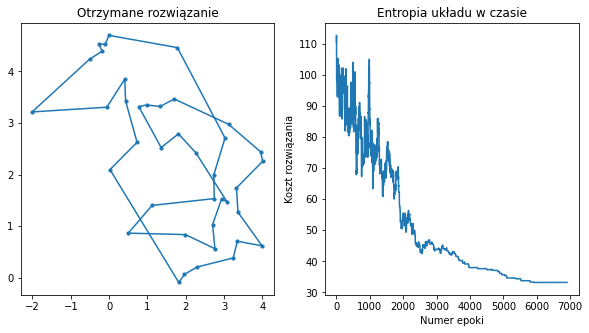

In [89]:
K = 10

cities = generate_normal_cities(K,
    np.random.rand(4, 2) * 5, [1]*4
)
show_example(cities, alpha=0.999)

- Random $\Sigma$
- $\mu \sim \text{Uniform}(0, 5)$
- $k = 5$

Current temperature: 0.09593780671429382 	 Current solution: 62.05382476544076 	 Best solution: 62.05382476544076 		Number of epochs without improvement reached max_stagnation

Number of epochs: 3841


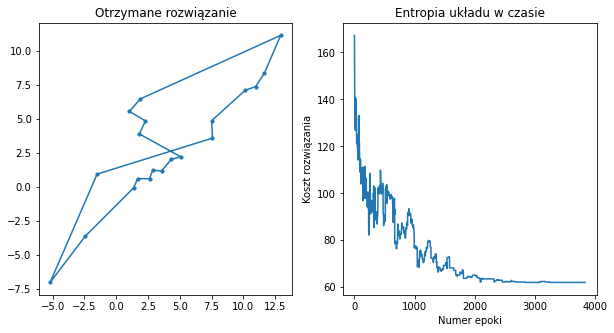

In [39]:
K = 5

Sigma =  np.random.rand(4, 2, 2) * 5
for i in range(4):
    # To create semi-definite matrix
    Sigma[i, ...] = Sigma[i, ...] @ Sigma[i, ...].T

cities = generate_normal_cities(K,
    np.random.rand(4, 2) * 5, Sigma
)
show_example(cities, alpha=0.999)

- $\Sigma = 1$
- $\mu_i = (i, i)$
- $k = 15$

Current temperature: 0.008941795172682832 	 Current solution: 47.47250123664897 	 Best solution: 47.47250123664897 		Number of epochs without improvement reached max_stagnation

Number of epochs: 13526


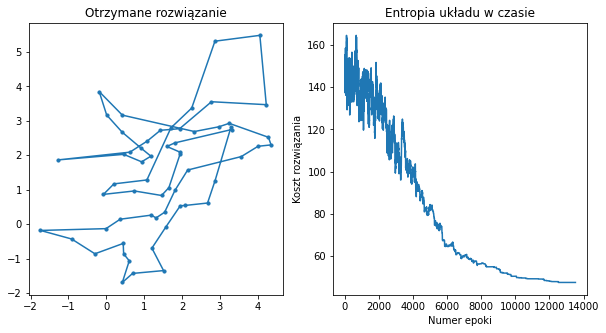

In [96]:
K = 15

mu = np.empty((4, 2))
mu[..., 0] = np.arange(4)
mu[..., 1] = mu[..., 0]

cities = generate_normal_cities(K,
    mu, [1]*4
)
show_example(cities, alpha=0.9995)

# Zbiory odseparowanych grup

- $c_i = (i \; \text{mod} \; 3, \lfloor \frac{i}{3} \rfloor)$ (krata)
- $r = 0.2$
- $k = 4$

Current temperature: 8.499185168413562e-05 	 Current solution: 18.45796590524345 	 Best solution: 18.45796590524345 		Number of epochs without improvement reached max_stagnation

Number of epochs: 5924


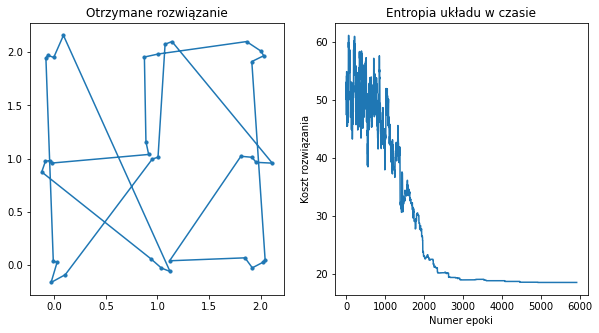

In [48]:
K = 4
c = np.empty((9, 2))
for i in range(9):
    c[i, 0] = i % 3
    c[i, 1] = floor(i/3)

cities = generate_circle_cities(K,
    c, [0.2]*9
)
show_example(cities, alpha=0.998, T0=lambda x: 2 * sqrt(x))

- $c_i \sim \text{Uniform}(0, 10)$
- $r_i \sim \text{Uniform}(0, 1)$
- $k = 5$

Current temperature: 0.00024128021953589204 	 Current solution: 49.169089967109784 	 Best solution: 49.169089967109784 		Number of epochs without improvement reached max_stagnation

Number of epochs: 12225


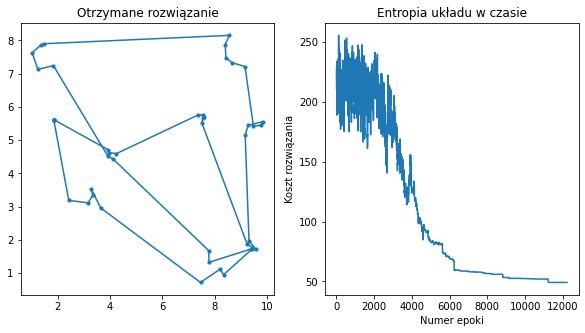

In [26]:
K = 5

c = np.random.rand(9, 2) * 10

cities = generate_circle_cities(5,
    np.random.rand(9, 2) * 10, np.random.rand(9)
)

cov = np.var(c)

show_example(cities, alpha=0.9989, T0=lambda x: 4 * sqrt(x) * cov)

- $c_i \sim \text{Uniform}(0, 10)$
- $r_i \sim \text{Uniform}(0, 1)$
- $k = 10$

Current temperature: 1.0005892167773207e-07 	 Current solution: 111.52680370490236 	 Best solution: 111.52680370490236 		Temperature dropped below epsilon

Number of epochs: 7223


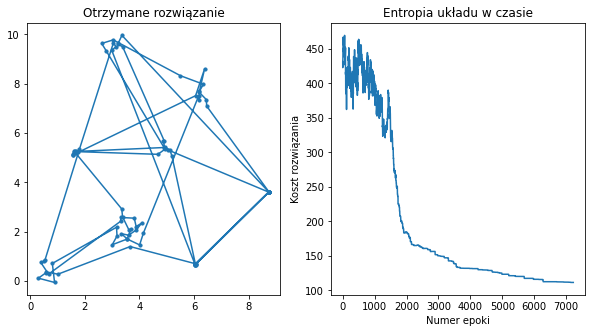

In [45]:
K = 10

c = np.random.rand(9, 2) * 10

cities = generate_circle_cities(K,
    np.random.rand(9, 2) * 10, np.random.rand(9)
)

cov = np.var(c)

show_example(cities, alpha=0.997, T0=lambda x: 4 * sqrt(x) * cov)

# Analiza zależności między hiperpametrami symulowanego wyżarzania a funkcją entropii układu w czasie

In [11]:
def plot_temperature_search(initial_temps, alphas, model, temp_model, max_stagnation=3000):
    m = len(initial_temps)
    n = len(alphas)
    fig, ax = plt.subplots(n, m)
    
    for X, init_temp in enumerate(initial_temps):
        for Y, alpha in enumerate(alphas):
            print(f'\rSolving {Y + X * n} / {n*m}', end='')
            model.model = temp_model
            _, score = model.fit(
                initial_temp=init_temp,
                alpha=alpha,
                max_stagnation=max_stagnation,
                epsilon=1e-8,
                verbose=False
            )
            story = model.story
            x = np.arange(len(story))
            y = [u[1] for u in story]
            ax[Y, X].plot(x, y)
            ax[Y, X].set_title('T0: {:.2f}, A: {:.4f}, Score: {:.2f}'.format(init_temp, alpha, score))

    fig.set_size_inches(4 * m, 4 * n)

## Zbiór losowych miast

# N = 20

Solving 17 / 18

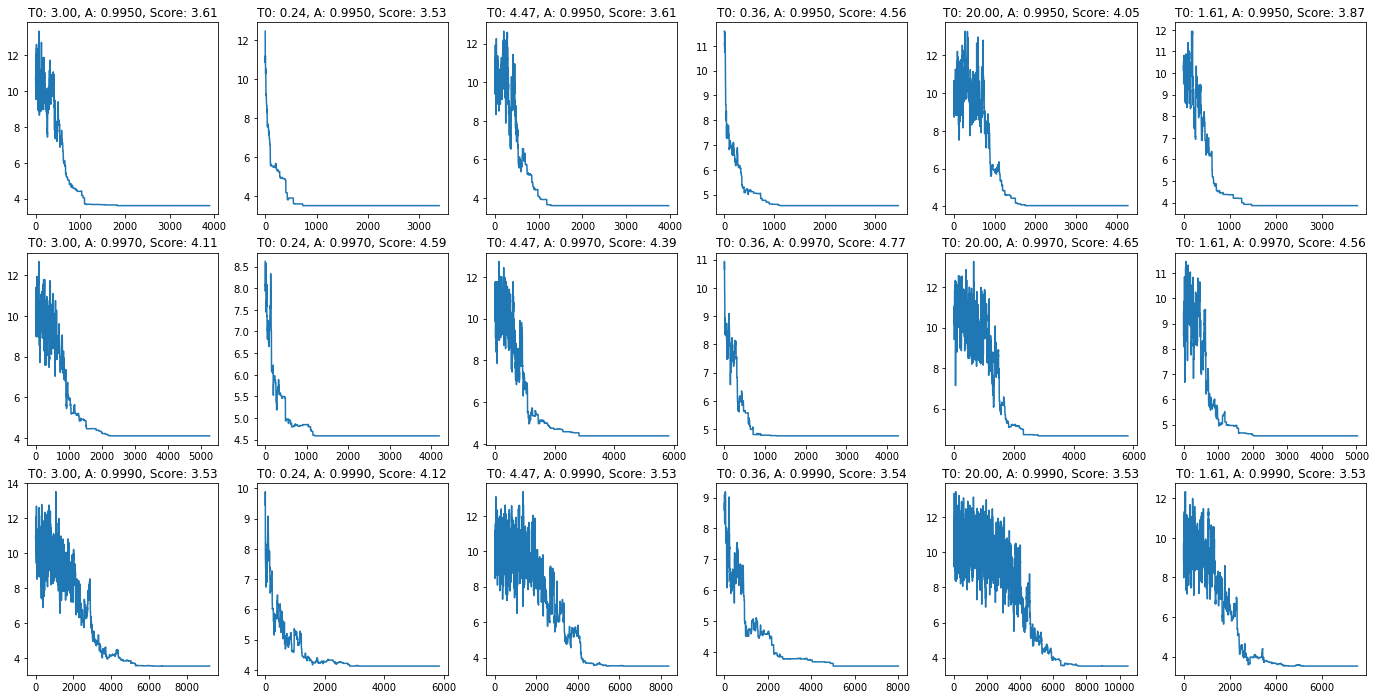

In [31]:
N = 20

cities = generate_random_cities(N)
var = np.var(cities)

model = TSPAnneal(
    cities
)
init_temps = [log(N), log(N) * var, sqrt(N), sqrt(N) * var, N, N * var]
alphas = [0.995, 0.997, 0.999]
plot_temperature_search(init_temps, alphas, model, model.exponential_model)

Na powyższej serii wykresów, w kolumnach znajdują się różne temperatury początkowe, zaś w wierszach różne współczynniki $\alpha$. Patrząc na powyższe wykresy możemy zauważyć nastepujące rzeczy:
- Temperatury początkowe wydaja się osiągać lepsze wykresy entropii w przypadku braku wariancji w równaniu. Sytuacja może się jednak w przypadku gdy miasta będą się znajdować poza kwadratem jednostkowym
- Najmniejszy współczynnik $\alpha=0.995$ daje zbyt krótki okres przeszukiwania.
- Najbardziej obiecujący wydaje się współczynnik $\alpha=0.999$ w połączeniu z funkcjami liniowymi lub pierwiastkowymi

### N = 50

Solving 23 / 24

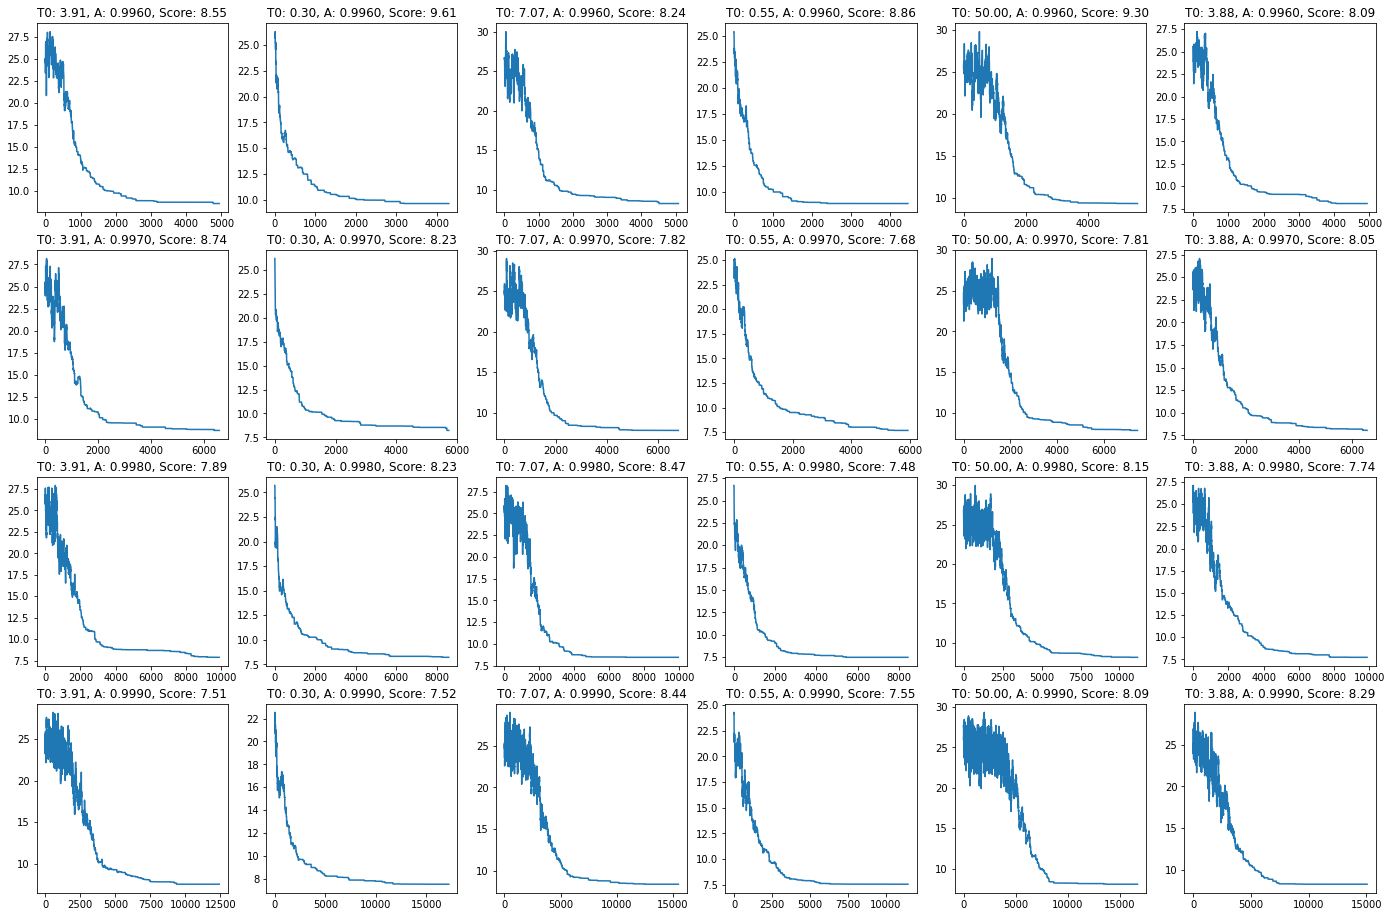

In [33]:
N = 50

cities = generate_random_cities(N)
var = np.var(cities)

model = TSPAnneal(
    cities
)
init_temps = [log(N), log(N) * var, sqrt(N), sqrt(N) * var, N, N * var]
alphas = [0.996, 0.997, 0.998, 0.999]
plot_temperature_search(init_temps, alphas, model, model.exponential_model)

W przypadku większej liczby miast możemy zauważyć, że logarytmiczne skorelowanie temperatury początkowej z liczbą miast daje zbyt niskie wartości.

### Przypadek gdy miasta znajdują się poza kwadratem jednostkowym, N = 45

Solving 23 / 24

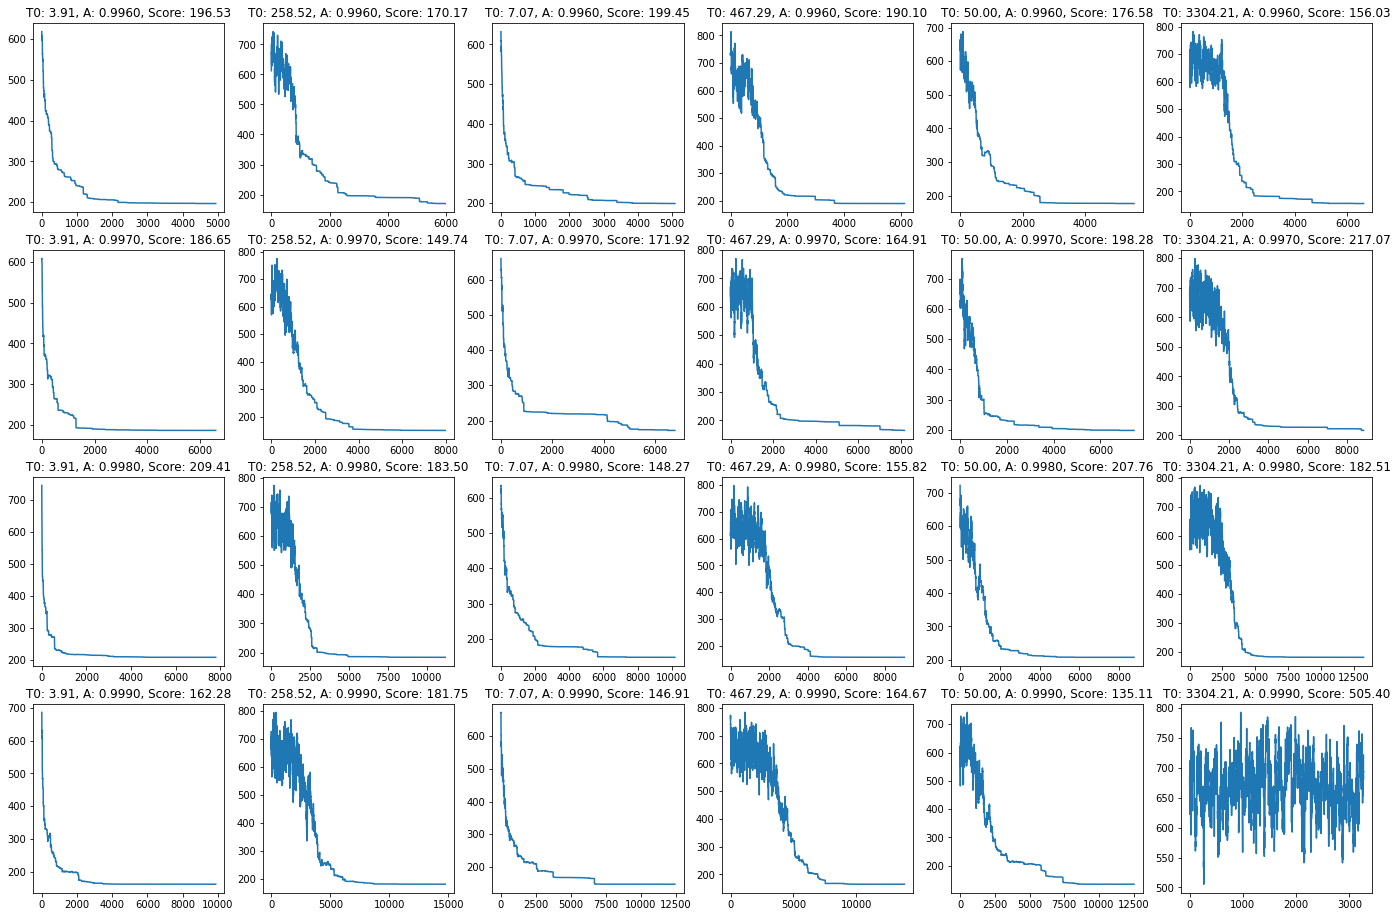

In [46]:
K = 5
c = np.empty((9, 2))
for i in range(9):
    c[i, 0] = 10 * (i % 3)
    c[i, 1] = 10 * floor(i/3)

cities = generate_circle_cities(5,
    c, [1]*9
)

var = np.var(cities)

model = TSPAnneal(
    cities
)
init_temps = [log(N), log(N) * var, sqrt(N), sqrt(N) * var, N, N * var]
alphas = [0.996, 0.997, 0.998, 0.999]
plot_temperature_search(init_temps, alphas, model, model.exponential_model)

W przypadku gdy odległości między miastami są większe niż 1, skorelowanie temperatury początkowej z wariancją położeń miast daje lepsze wykresy zachowania energii (Pomijąc pojedyńczy przypadek dla $\alpha=0.999$ $T_0=3304.21$).

# Inne funkcje temperatury

## Funkcja liniowa

Solving 19 / 20

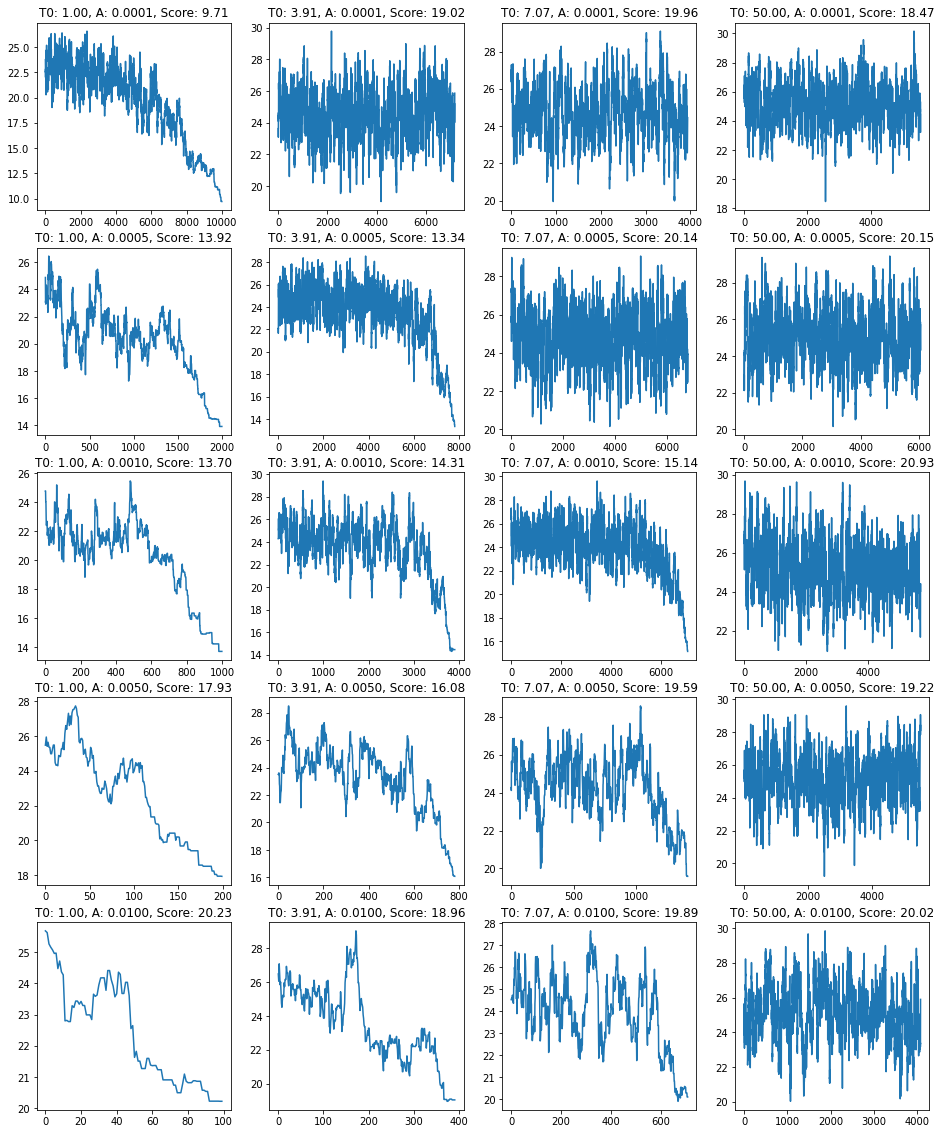

In [19]:
N = 50

cities = generate_random_cities(N)
var = np.var(cities)

model = TSPAnneal(
    cities
)
init_temps = [1, log(N), sqrt(N), N]
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
plot_temperature_search(init_temps, alphas, model, model.linear_model)

Z powyższych prób, jedynie $T_0 = 1, \alpha = 0.0001$ osiąga zadowolające wyniki. Temperatury początkowe wykorzystywane przy modelu eksponencjalnym okazują się zbyt wysokie, przez temperatura za szybko schodzi do wartości $\epsilon$ (szczególnie widocznie dla największych $\alpha$), bądź okres przeszukiwania sąsiedztwa z wysokim prawdopodobieństwem (pierwsza faza) trwa za długo.

Solving 15 / 16

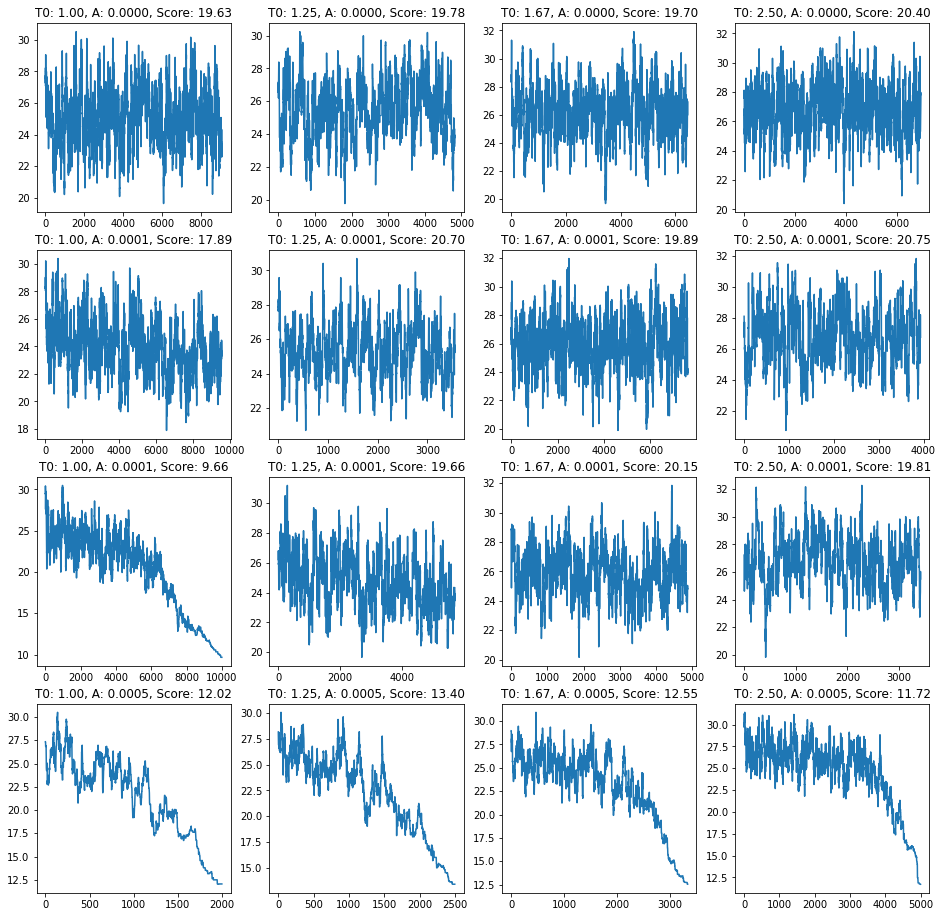

In [20]:
N = 50

cities = generate_random_cities(N)
var = np.var(cities)

model = TSPAnneal(
    cities
)
init_temps = [N / 50, N / 40, N / 30, N / 20]
alphas = [0.00001, 0.00005, 0.0001, 0.0005]
plot_temperature_search(init_temps, alphas, model, model.linear_model)

Możemy zauważyć, że wartości $\alpha < 0.0001$ dają nam niepoprawne zachowanie modelu wyżarzania. Najlepszym spośród testowanych zbiorów hiperparametrów dla modelu liniowego na zbiorze losowych miast wewnątrz kwadratu jednostkowego jest $T_0 = \frac{|N|}{50}, \alpha = 0.0001$. Dostrajanie modelu liniowego okazuje się być bardziej problematycznym procesem. Główną trudnością jest dobór parametrów dla których etap spadku do minimum będzie trwał wystarczająco długo.

# Wpływ metody wybierania sąsiedztwa na wyniki

In [67]:
def compare_swaps(generator=generate_random_cities, sizes=[10, 20, 30, 40, 50], alpha=0.997, T0=sqrt):
    fig, ax = plt.subplots(2, len(sizes))
    
    for X, arb in enumerate([True, False]):
        for Y, size in enumerate(sizes):
            print(f'\rSolving {X * len(sizes) + Y} / {2 * len(sizes)}', end='')
            cities = generator(size)
            model = TSPAnneal(
                cities,
                use_arbitrary=arb
            )
            _, score = model.fit(
                alpha=alpha,
                initial_temp=T0(cities.shape[0]),
                epsilon=1e-7,
                max_stagnation=1000,
                verbose=False
            )
            story = model.story
            x = np.arange(len(story))
            y = [u[1] for u in story]
            ax[X, Y].plot(x, y)
            ax[X, Y].set_title('Swap: {} Size: {} Score: {:.2f}'.format("arb" if arb else "con", cities.shape[0], score))
    
    
    fig.set_size_inches(len(sizes) * 4, 8)

Solving 9 / 10

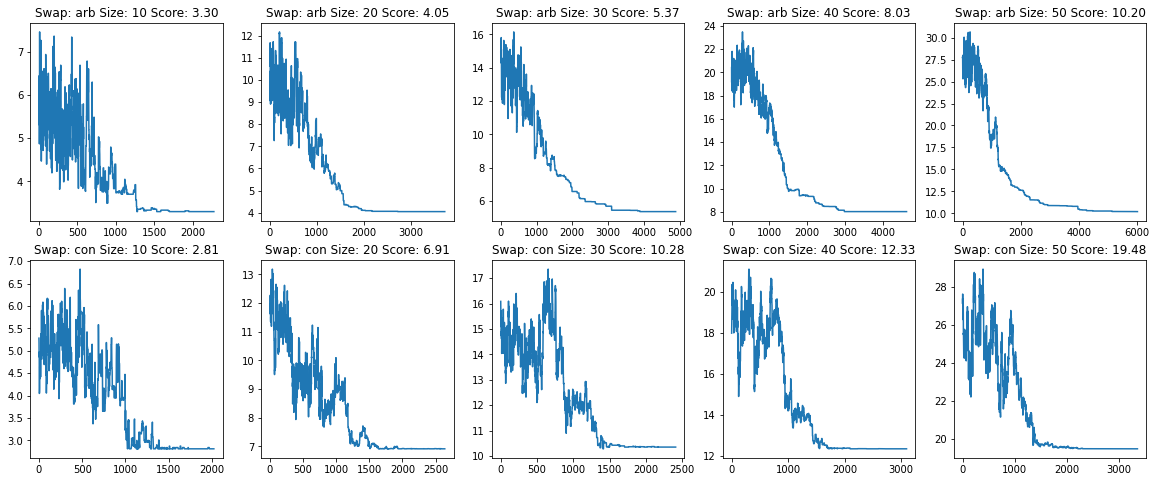

In [68]:
compare_swaps()

Na podstawie powyższych wykresów możemy zauważyć, że _consecutive swap_ osiąga znacząco gorsze wyniki niż _arbitrary swap_. Ponadto kształty zależności entropii od układu są znacząco bardziej chaotyczne dla _consecutive swap_ (widoczne są poszarpania na wykresach).

# Zapisywanie wizualizacji procesu wyżarzania do pliku

Poniższa funkcja zapisuje wyniki modelu pliku z podanego do niej obiektu `TSPAnneal`. W wizualizacji przentowane są aktualnie rozważane rozwiązanie oraz entropia układu do danej chwili. W związku z liczbą iteracji wizualizator zapisuje tylko część kroków w równomiernych odstępach. 

In [202]:
def save_to_file(model, filename, frames=100):
    story = model.story
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 10)
    cam = Camera(fig)
    epochs = len(story)
    scores = []
    x = []
    for i, (sol, _score) in enumerate(story):
        scores.append(_score)
        x.append(i)
        if i % (epochs // frames) != 0:
            continue
        plot_cities(ax[0], cities, sol)
        ax[1].plot(x, scores)
        cam.snap()
        print(f'\rCurrent {i} / {epochs}', end='')
    cam.animate().save(filename)

Current temperature: 0.0006208075492296161 	 Current solution: 5.996353739196564 	 Best solution: 5.99635373919656455
Number of epochs: 4539
Current 4500 / 4539

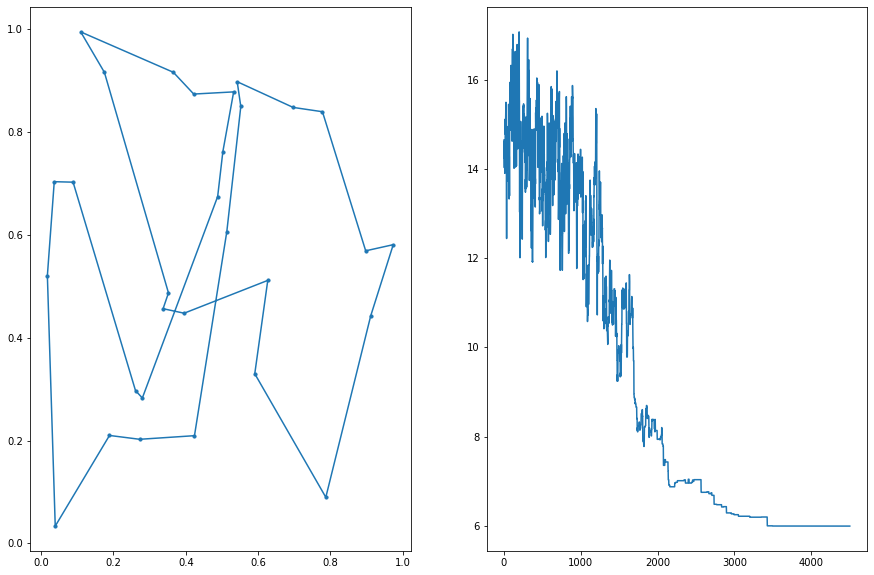

In [206]:
cities = generate_random_cities(30)
model = TSPAnneal(cities)
sol, score = model.fit(
    initial_temp=sqrt(cities.shape[0]),
    alpha=0.998,
    max_stagnation=1000,
    epsilon=1e-7
)
save_to_file(model, 'example.mp4')

# Bibliografia
[1] Traveling-Salesman-Problem Algorithm Based on Simulated Annealing and Gene-Expression Programming </br> Ai-Hua Zhou, Li-Peng Zhu, Bin Hu, Song Deng, Yan Song, Hongbin Qiu, Sen Pan </br> https://www.mdpi.com/2078-2489/10/1/7

[2] Simulated Annealing </br> Wikipedia </br> https://en.wikipedia.org/wiki/Simulated_annealing

[3] Genetic Algorithms vs. Simulated Annealing: A Comparison of Approaches for Solving the Circuit Partitioning Problem </br>Theodore W. Manikas, James T. Cain </br> https://scholar.smu.edu/engineering_compsci_research/1/